# Predicting EUR/USD pair using LSTM 

Epoch 1/10
271/271 [==============================] - 2s 4ms/step - loss: 0.0052 - val_loss: 1.4165e-04
Epoch 2/10
271/271 [==============================] - 1s 3ms/step - loss: 8.8640e-04 - val_loss: 2.1676e-04
Epoch 3/10
271/271 [==============================] - 1s 3ms/step - loss: 7.1869e-04 - val_loss: 9.5716e-05
Epoch 4/10
271/271 [==============================] - 1s 3ms/step - loss: 6.4169e-04 - val_loss: 1.0600e-04
Epoch 5/10
271/271 [==============================] - 1s 3ms/step - loss: 5.8322e-04 - val_loss: 8.2340e-05
Epoch 6/10
271/271 [==============================] - 1s 3ms/step - loss: 5.3461e-04 - val_loss: 8.4773e-05
Epoch 7/10
271/271 [==============================] - 1s 3ms/step - loss: 4.8461e-04 - val_loss: 8.4050e-05
Epoch 8/10
271/271 [==============================] - 1s 3ms/step - loss: 4.4020e-04 - val_loss: 1.0995e-04
Epoch 9/10
271/271 [==============================] - 1s 3ms/step - loss: 4.1318e-04 - val_loss: 6.9320e-05
Epoch 10/10
68/68 [=============

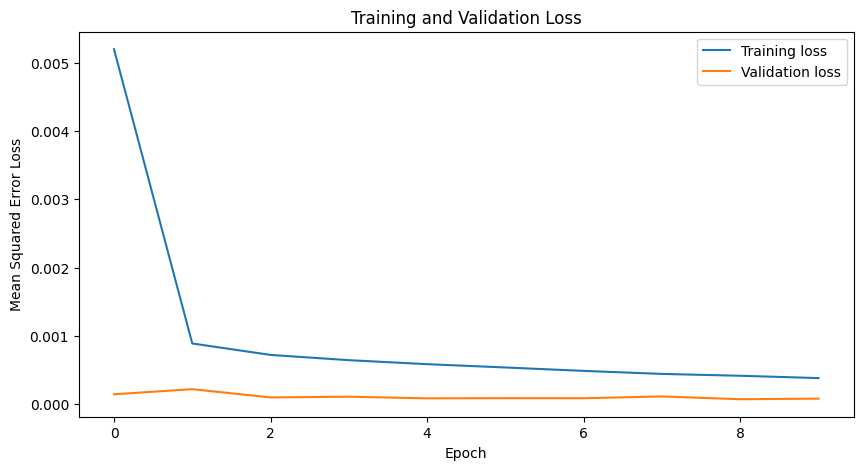

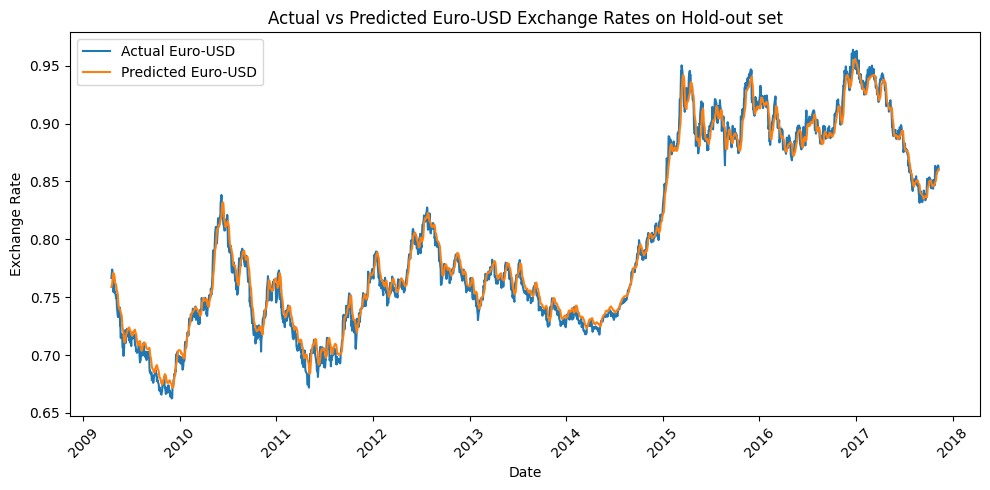

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# -----------------------------
# 1. Load and preprocess the data
# -----------------------------
# Read the CSV file – adjust the file path as needed.
data = pd.read_csv("BOE-XUDLERD.csv")
# Convert the Date column to datetime and sort it in ascending order
data['Date'] = pd.to_datetime(data['Date'])
data.sort_values('Date', inplace=True)
data.reset_index(drop=True, inplace=True)

# Use only the "Value" column (assumed to be the euro-USD rate)
dataset = data[['Value']].values.astype('float32')

# Scale the dataset to [0, 1] range using MinMaxScaler for better LSTM performance
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

# -----------------------------
# 2. Create time-series sequences
# -----------------------------
# Define a look_back (window size) – for example, use the previous 10 days to predict the next day.
look_back = 10

def create_sequences(dataset, look_back):
    X, y = [], []
    for i in range(len(dataset) - look_back):
        seq_x = dataset[i:(i + look_back), 0]
        seq_y = dataset[i + look_back, 0]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

X, y = create_sequences(scaled_data, look_back)

# Reshape X for LSTM input: (samples, timesteps, features)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

# -----------------------------
# 3. Split into training and hold-out (test) datasets
# -----------------------------
# For time series it is common to use the earlier 80% for training and the later 20% as hold-out
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# -----------------------------
# 4. Build the LSTM model
# -----------------------------
model = Sequential()
# First LSTM layer with 50 units; you can add dropout for regularization
model.add(LSTM(50, return_sequences=False, input_shape=(look_back, 1)))
model.add(Dropout(0.2))
# A Dense output layer predicting the next value
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

# -----------------------------
# 5. Train the model
# -----------------------------
history = model.fit(X_train, y_train, 
                    epochs=10, 
                    batch_size=32, 
                    validation_data=(X_test, y_test),
                    verbose=1)

# -----------------------------
# 6. Make predictions on the hold-out set and inverse-transform the results
# -----------------------------
y_pred_scaled = model.predict(X_test)
y_test_scaled = y_test.reshape(-1, 1)

# Inverse scale predictions and actual values
y_pred = scaler.inverse_transform(y_pred_scaled)
y_test_actual = scaler.inverse_transform(y_test_scaled)

# -----------------------------
# 7. Compute performance metrics
# -----------------------------
mse = mean_squared_error(y_test_actual, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_actual, y_pred)
mape = np.mean(np.abs((y_test_actual - y_pred) / y_test_actual)) * 100
r2 = r2_score(y_test_actual, y_pred)

print("Model Performance on Hold-out Test Set:")
print(f"RMSE: {rmse:.4f}")
print(f"MSE: {mse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"MAPE: {mape:.2f}%")
print(f"R^2 Score: {r2:.4f}")

# -----------------------------
# 8. Plot relevant graphs and figures
# -----------------------------
# Plot training and validation loss over epochs
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title("Training and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Mean Squared Error Loss")
plt.legend()
plt.show()

# Plot actual vs predicted values on the hold-out set
plt.figure(figsize=(10, 5))
plt.plot(data['Date'][-len(y_test_actual):], y_test_actual, label='Actual Euro-USD')
plt.plot(data['Date'][-len(y_test_actual):], y_pred, label='Predicted Euro-USD')
plt.xlabel("Date")
plt.ylabel("Exchange Rate")
plt.title("Actual vs Predicted Euro-USD Exchange Rates on Hold-out set")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


Training on the full dataset...
Epoch 1/10
339/339 [==============================] - 4s 3ms/step - loss: 0.0029
Epoch 2/10
339/339 [==============================] - 1s 3ms/step - loss: 6.3213e-04
Epoch 3/10
339/339 [==============================] - 1s 3ms/step - loss: 5.7212e-04
Epoch 4/10
339/339 [==============================] - 1s 3ms/step - loss: 4.9351e-04
Epoch 5/10
339/339 [==============================] - 1s 3ms/step - loss: 4.5327e-04
Epoch 6/10
339/339 [==============================] - 1s 3ms/step - loss: 3.8440e-04
Epoch 7/10
339/339 [==============================] - 1s 3ms/step - loss: 3.5945e-04
Epoch 8/10
339/339 [==============================] - 1s 3ms/step - loss: 3.1573e-04
Epoch 9/10
339/339 [==============================] - 1s 3ms/step - loss: 2.8935e-04
Epoch 10/10
339/339 [==============================] - 1s 1ms/step

Performance on the Full Dataset:
RMSE: 0.0086
MSE: 0.0001
MAE: 0.0064
MAPE: 0.74%
R^2: 0.9968


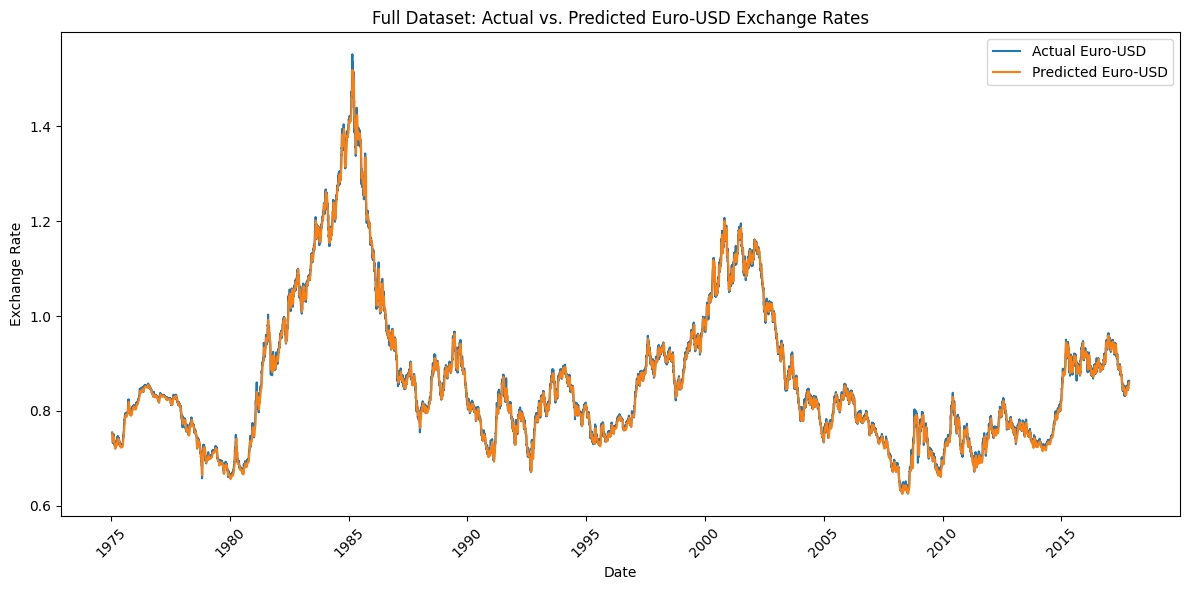

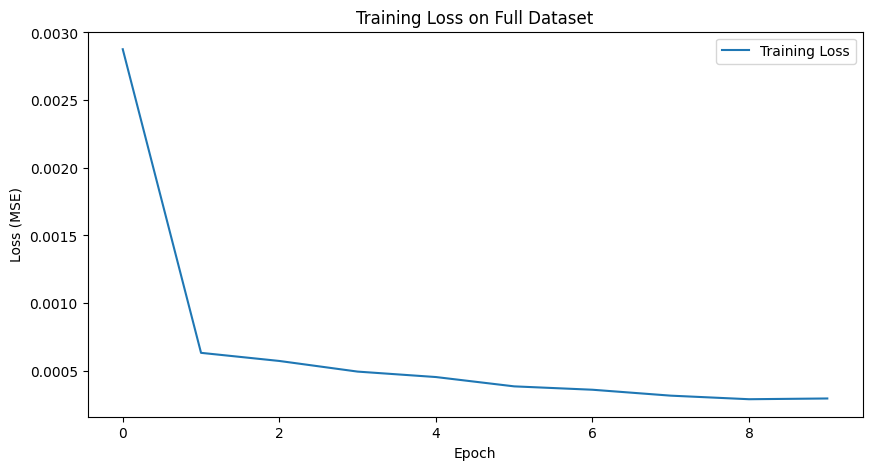


Training on 80% Train / 20% Test split...
Epoch 1/10
271/271 [==============================] - 2s 4ms/step - loss: 0.0033 - val_loss: 1.0048e-04
Epoch 2/10
271/271 [==============================] - 1s 3ms/step - loss: 7.6907e-04 - val_loss: 1.0732e-04
Epoch 3/10
271/271 [==============================] - 1s 3ms/step - loss: 6.9840e-04 - val_loss: 8.2187e-05
Epoch 4/10
271/271 [==============================] - 1s 3ms/step - loss: 6.0674e-04 - val_loss: 8.1512e-05
Epoch 5/10
271/271 [==============================] - 1s 3ms/step - loss: 5.2528e-04 - val_loss: 7.2064e-05
Epoch 6/10
271/271 [==============================] - 1s 3ms/step - loss: 4.6586e-04 - val_loss: 7.0555e-05
Epoch 7/10
271/271 [==============================] - 1s 3ms/step - loss: 4.2178e-04 - val_loss: 6.6818e-05
Epoch 8/10
271/271 [==============================] - 1s 3ms/step - loss: 3.9264e-04 - val_loss: 6.4630e-05
Epoch 9/10
271/271 [==============================] - 1s 3ms/step - loss: 3.7741e-04 - val_loss: 

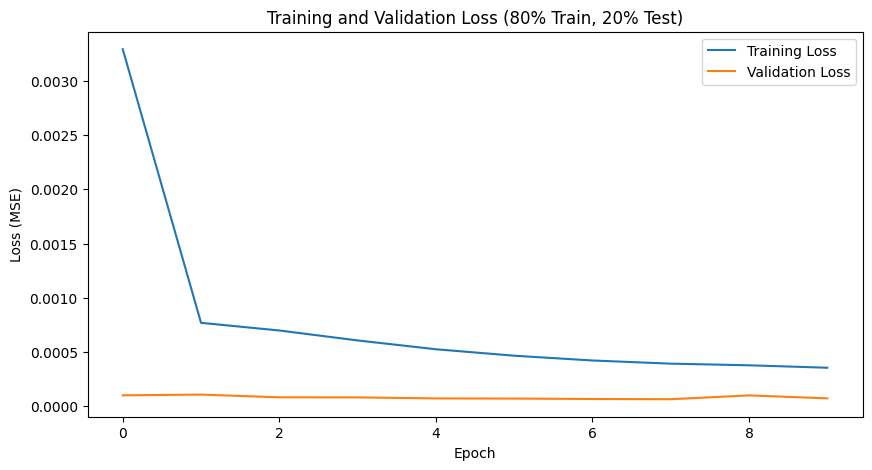

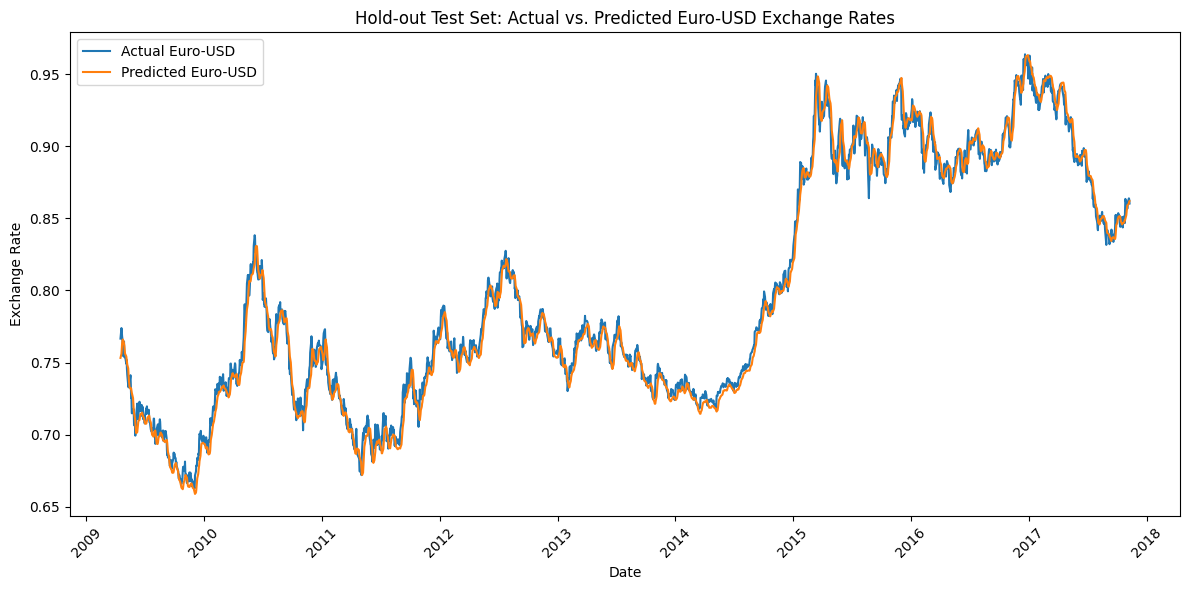

68/68 [==============================] - 0s 2ms/step


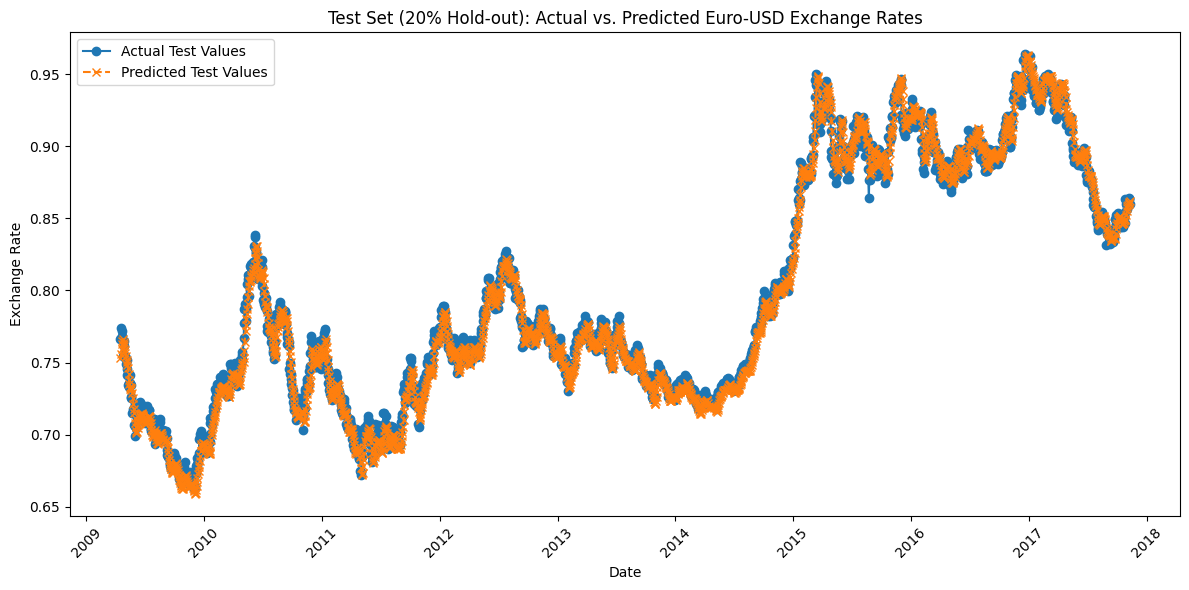

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# -----------------------------
# 1. Load and Preprocess the Data
# -----------------------------
# Adjust the file path as necessary.
data = pd.read_csv("BOE-XUDLERD.csv")

# Convert the Date column to datetime and sort in ascending order.
data['Date'] = pd.to_datetime(data['Date'])
data.sort_values('Date', inplace=True)
data.reset_index(drop=True, inplace=True)

# Use only the "Value" column (assumed to be the Euro-USD rate).
dataset = data[['Value']].values.astype('float32')

# Scale the dataset to the [0, 1] range for the LSTM.
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

# -----------------------------
# 2. Create Time-Series Sequences
# -----------------------------
look_back = 10  # Number of previous time steps used for predicting the next value

def create_sequences(dataset, look_back):
    X, y = [], []
    for i in range(len(dataset) - look_back):
        seq_x = dataset[i:(i + look_back), 0]
        seq_y = dataset[i + look_back, 0]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

# Create sequences from the scaled data.
X_full, y_full = create_sequences(scaled_data, look_back)
# Reshape to [samples, timesteps, features] for LSTM input.
X_full = np.reshape(X_full, (X_full.shape[0], X_full.shape[1], 1))

# -----------------------------
# 3. Define the LSTM Model Building Function
# -----------------------------
def build_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(50, return_sequences=False, input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# -----------------------------
# 4. Scenario 1: Train and Evaluate on the Full Dataset
# -----------------------------
print("Training on the full dataset...")

# Build and train the LSTM model using the entire dataset.
model_full = build_lstm_model((look_back, 1))
history_full = model_full.fit(X_full, y_full, epochs=10, batch_size=32, verbose=1)

# Make predictions on the full dataset.
y_pred_full_scaled = model_full.predict(X_full)
y_pred_full = scaler.inverse_transform(y_pred_full_scaled)
y_full_actual = scaler.inverse_transform(y_full.reshape(-1, 1))

# Compute performance metrics.
mse_full  = mean_squared_error(y_full_actual, y_pred_full)
rmse_full = np.sqrt(mse_full)
mae_full  = mean_absolute_error(y_full_actual, y_pred_full)
mape_full = np.mean(np.abs((y_full_actual - y_pred_full) / y_full_actual)) * 100
r2_full   = r2_score(y_full_actual, y_pred_full)

print("\nPerformance on the Full Dataset:")
print(f"RMSE: {rmse_full:.4f}")
print(f"MSE: {mse_full:.4f}")
print(f"MAE: {mae_full:.4f}")
print(f"MAPE: {mape_full:.2f}%")
print(f"R^2: {r2_full:.4f}")

# Plot Actual vs. Predicted exchange rates for the full dataset.
plt.figure(figsize=(12, 6))
plt.plot(data['Date'][look_back:], y_full_actual, label='Actual Euro-USD')
plt.plot(data['Date'][look_back:], y_pred_full, label='Predicted Euro-USD')
plt.title("Full Dataset: Actual vs. Predicted Euro-USD Exchange Rates")
plt.xlabel("Date")
plt.ylabel("Exchange Rate")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot the training loss over epochs.
plt.figure(figsize=(10, 5))
plt.plot(history_full.history['loss'], label='Training Loss')
plt.title("Training Loss on Full Dataset")
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
plt.legend()
plt.show()

# -----------------------------
# 5. Scenario 2: Train-Test Split (80% Train, 20% Test)
# -----------------------------
print("\nTraining on 80% Train / 20% Test split...")

# Calculate split index based on the number of sequences.
train_size = int(len(X_full) * 0.8)
X_train, X_test = X_full[:train_size], X_full[train_size:]
y_train, y_test = y_full[:train_size], y_full[train_size:]

# Build and train a new LSTM model using the training split.
model_hold = build_lstm_model((look_back, 1))
history_hold = model_hold.fit(X_train, y_train, epochs=10, batch_size=32,
                              validation_data=(X_test, y_test), verbose=1)

# Make predictions on the hold-out test set.
y_pred_hold_scaled = model_hold.predict(X_test)
y_pred_hold = scaler.inverse_transform(y_pred_hold_scaled)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Compute performance metrics for the hold-out test set.
mse_hold  = mean_squared_error(y_test_actual, y_pred_hold)
rmse_hold = np.sqrt(mse_hold)
mae_hold  = mean_absolute_error(y_test_actual, y_pred_hold)
mape_hold = np.mean(np.abs((y_test_actual - y_pred_hold) / y_test_actual)) * 100
r2_hold   = r2_score(y_test_actual, y_pred_hold)

print("\nPerformance on the Hold-out Test Set:")
print(f"RMSE: {rmse_hold:.4f}")
print(f"MSE: {mse_hold:.4f}")
print(f"MAE: {mae_hold:.4f}")
print(f"MAPE: {mape_hold:.2f}%")
print(f"R^2: {r2_hold:.4f}")

# Plot training and validation loss for the split approach.
plt.figure(figsize=(10, 5))
plt.plot(history_hold.history['loss'], label='Training Loss')
plt.plot(history_hold.history['val_loss'], label='Validation Loss')
plt.title("Training and Validation Loss (80% Train, 20% Test)")
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
plt.legend()
plt.show()

# Determine the corresponding dates for the test set.
dates_test = data['Date'].iloc[train_size + look_back:].reset_index(drop=True)

# Plot Actual vs. Predicted exchange rates for the test set.
plt.figure(figsize=(12, 6))
plt.plot(dates_test, y_test_actual, label='Actual Euro-USD')
plt.plot(dates_test, y_pred_hold, label='Predicted Euro-USD')
plt.title("Hold-out Test Set: Actual vs. Predicted Euro-USD Exchange Rates")
plt.xlabel("Date")
plt.ylabel("Exchange Rate")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# --- Make predictions on the test set ---
y_pred_scaled = model_hold.predict(X_test)
y_pred = scaler.inverse_transform(y_pred_scaled)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# --- Calculate the corresponding dates for the test set ---
# Since sequences were created using a 'look_back' window,
# the first sequence corresponds to data[look_back:]. Therefore, the test dates are the
# dates from index (train_size + look_back) to the end.
dates_test = data['Date'].iloc[train_size + look_back:].reset_index(drop=True)

# --- Plot only the test values (20% hold-out) ---
plt.figure(figsize=(12, 6))
plt.plot(dates_test, y_test_actual, label='Actual Test Values', marker='o')
plt.plot(dates_test, y_pred, label='Predicted Test Values', linestyle='--', marker='x')
plt.title('Test Set (20% Hold-out): Actual vs. Predicted Euro-USD Exchange Rates')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()
